In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/facial_expression

/content/drive/MyDrive/facial_expression


In [ ]:
!ls

fer2013  fer2013.tar.gz  images


In [ ]:
import tarfile


fname = 'fer2013.tar.gz'
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator



In [ ]:
# Load the FER2013 dataset (you can download it from Kaggle or other sources)
# The dataset contains 'emotion', 'pixels', and 'usage' columns
data = pd.read_csv('/content/drive/MyDrive/facial_expression/fer2013/fer2013.csv')

In [ ]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

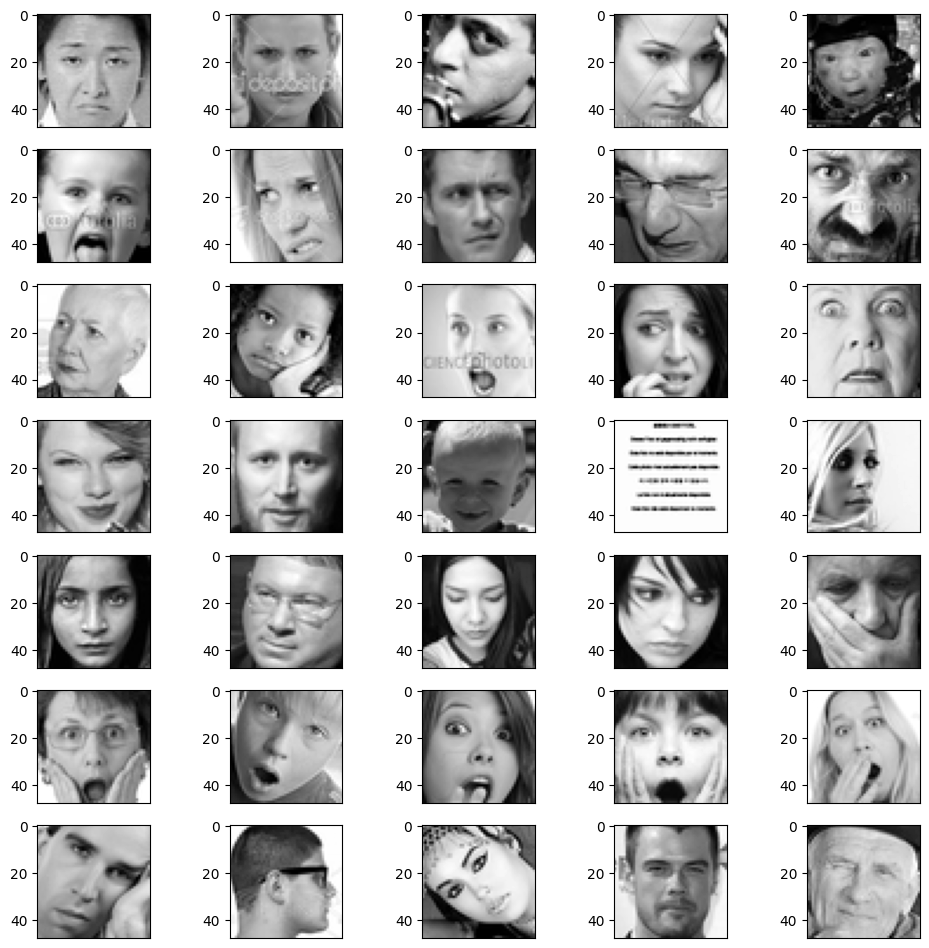

In [ ]:
# Plot a sample of facial emotion images
num_samples_per_emotion = 5
fig, axs = plt.subplots(7, num_samples_per_emotion, figsize=(12, 12))
for i, emotion_label in enumerate(sorted(data.emotion.unique())):
    sample_emotion_data = data[data.emotion == emotion_label].sample(num_samples_per_emotion)
    for j, (_, sample_row) in enumerate(sample_emotion_data.iterrows()):
        img = np.fromstring(sample_row['pixels'], dtype=int, sep=' ').reshape(48, 48)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_xticks([])

In [ ]:
# Function to preprocess the input image
def preprocess_input_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))  # Resize the image to match the model's input shape
    img = img / 255.0  # Normalize pixel values to range [0, 1]
    img = img.reshape(1, 48, 48, 1)  # Reshape to match the model's input shape (batch size = 1)
    return img

In [ ]:
# Process the 'pixels' column to convert strings to numpy arrays
data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))

In [ ]:
# Convert pixel values to range [0, 1]
data['pixels'] = data['pixels'] / 255.0

In [ ]:
# Extract images and labels from the dataset
X = np.array(data['pixels'].tolist())
y = np.array(data['emotion'])

In [ ]:
# Reshape the images to (48, 48, 1) since they are grayscale (48x48 pixels)
X = X.reshape(-1, 48, 48, 1)

In [ ]:
# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=7)

In [ ]:
# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Used Early stopping to avoid overfitting
callback = tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            mode = 'min',
                                            patience=5
                                           )

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output before fully connected layers
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))  # 7 output neurons for 7 emotions

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Data augmentation to increase dataset size and improve generalization
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

In [ ]:
# Train the model
batch_size = 128  # You can adjust this based on memory availability
epochs = 40

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train) / batch_size,
                              epochs=epochs,
                              validation_data=(X_val, y_val),
                              verbose=1,
                              callbacks = [callback])  # Use early stopping if available



<ipython-input-29-08e46c621b82>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),


Epoch 1/40
179/179 [==============================] - 12s 62ms/step - loss: 1.1046 - accuracy: 0.5851 - val_loss: 1.0748 - val_accuracy: 0.5970
Epoch 2/40
179/179 [==============================] - 9s 53ms/step - loss: 1.0905 - accuracy: 0.5907 - val_loss: 1.0600 - val_accuracy: 0.6000
Epoch 3/40
179/179 [==============================] - 12s 64ms/step - loss: 1.0943 - accuracy: 0.5856 - val_loss: 1.0649 - val_accuracy: 0.5986
Epoch 4/40
179/179 [==============================] - 11s 62ms/step - loss: 1.0980 - accuracy: 0.5878 - val_loss: 1.0619 - val_accuracy: 0.5975
Epoch 5/40
179/179 [==============================] - 11s 61ms/step - loss: 1.0953 - accuracy: 0.5880 - val_loss: 1.0776 - val_accuracy: 0.5953
Epoch 6/40
179/179 [==============================] - 11s 59ms/step - loss: 1.0946 - accuracy: 0.5897 - val_loss: 1.0714 - val_accuracy: 0.5956
Epoch 7/40
179/179 [==============================] - 11s 61ms/step - loss: 1.0924 - accuracy: 0.5896 - val_loss: 1.0607 - val_accuracy: 

In [ ]:
# Train the model
batch_size = 32
epochs = 40
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
                              validation_data=(X_val, y_val))

Epoch 1/40


<ipython-input-22-9c8fa803896e>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),


717/717 [==============================] - 13s 18ms/step - loss: 1.1715 - accuracy: 0.5594 - val_loss: 1.1050 - val_accuracy: 0.5843
Epoch 2/40
717/717 [==============================] - 12s 16ms/step - loss: 1.1652 - accuracy: 0.5608 - val_loss: 1.0903 - val_accuracy: 0.5874
Epoch 3/40
717/717 [==============================] - 12s 17ms/step - loss: 1.1533 - accuracy: 0.5611 - val_loss: 1.0973 - val_accuracy: 0.5838
Epoch 4/40
717/717 [==============================] - 13s 18ms/step - loss: 1.1505 - accuracy: 0.5700 - val_loss: 1.0887 - val_accuracy: 0.5792
Epoch 5/40
717/717 [==============================] - 13s 18ms/step - loss: 1.1422 - accuracy: 0.5679 - val_loss: 1.1247 - val_accuracy: 0.5707
Epoch 6/40
717/717 [==============================] - 13s 18ms/step - loss: 1.1406 - accuracy: 0.5699 - val_loss: 1.0953 - val_accuracy: 0.5914
Epoch 7/40
717/717 [==============================] - 13s 18ms/step - loss: 1.1380 - accuracy: 0.5699 - val_loss: 1.0805 - val_accuracy: 0.5951
Epo

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

225/225 [==============================] - 1s 4ms/step - loss: 1.1117 - accuracy: 0.5809
Test accuracy: 0.5809417963027954


In [ ]:
import cv2

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import load_model

model.save('/content/drive/MyDrive/facial_expression.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/facial_expression.h5')

In [ ]:
# Function to preprocess the input image
def preprocess_input_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))  # Resize the image to match the model's input shape
    img = img / 255.0  # Normalize pixel values to range [0, 1]
    img = img.reshape(1, 48, 48, 1)  # Reshape to match the model's input shape (batch size = 1)
    return img

In [ ]:
# Function to get the predicted emotion label from the model's output
def get_predicted_emotion(predictions):
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    predicted_label_index = np.argmax(predictions)
    predicted_emotion = emotion_labels[predicted_label_index]
    return predicted_emotion

In [ ]:
# Example usage:
input_image_path = '/content/drive/MyDrive/facial_expression/images/validation/happy/10019.jpg'  # Replace with the actual path to your input image
input_image = preprocess_input_image(input_image_path)
predictions = model.predict(input_image)
predicted_emotion = get_predicted_emotion(predictions[0])

print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 121ms/step
Predicted Emotion: happy


1/1 [==============================] - 0s 16ms/step
0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral' ,Enter the actual label index (0-6): 0


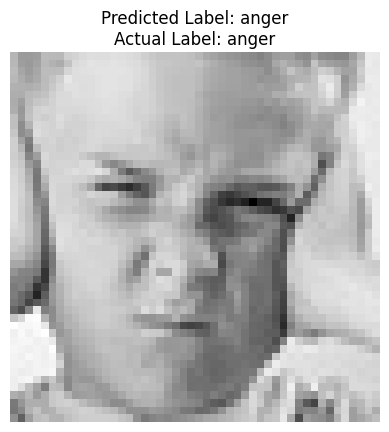

In [ ]:


# Provide the image path
input_image_path = '/content/drive/MyDrive/facial_expression/images/validation/angry/10079.jpg'  # Replace with the actual path to your input image

# Preprocess the input image and make predictions using the trained model
input_image = preprocess_input_image(input_image_path)
predictions = model.predict(input_image)
predicted_label_index = np.argmax(predictions)
predicted_emotion = label_to_text[predicted_label_index]

# Get the actual label of the image from the dataset
actual_label_index = int(input("0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral' ,Enter the actual label index (0-6): "))
actual_emotion = label_to_text[actual_label_index]

# Load the input image for visualization
input_img = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

# Plot the input image along with its predicted and actual labels
plt.imshow(input_img, cmap='gray')
plt.title(f'Predicted Label: {predicted_emotion}\nActual Label: {actual_emotion}')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 83ms/step


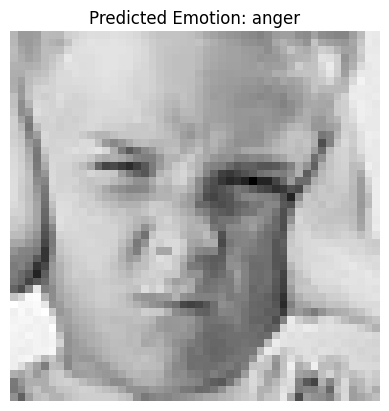

In [ ]:
# Provide the image path for prediction
input_image_path = '/content/drive/MyDrive/facial_expression/images/validation/angry/10079.jpg'  # Replace with the actual path to your input image

# Preprocess the input image and make predictions using the trained model
input_image = preprocess_input_image(input_image_path)
predictions = model.predict(input_image)
predicted_label_index = np.argmax(predictions)
predicted_emotion = label_to_text[predicted_label_index]

# Load the input image for visualization
input_img = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

# Plot the input image along with its predicted label
plt.imshow(input_img, cmap='gray')
plt.title(f'Predicted Emotion: {predicted_emotion}')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 22ms/step


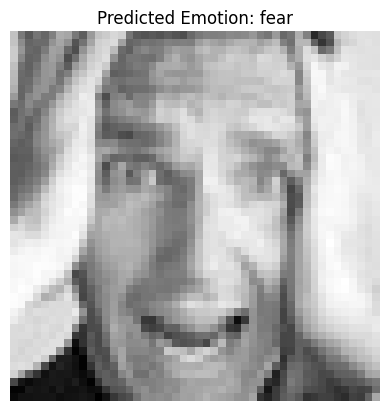

In [ ]:
#/content/drive/MyDrive/facial_expression/images/validation/disgust/10053.jpg
#/content/drive/MyDrive/facial_expression/images/validation/fear/10043.jpg
#/content/drive/MyDrive/facial_expression/images/validation/angry/10079.jpg

# Provide the image path for prediction
input_image_path = '/content/drive/MyDrive/facial_expression/images/validation/fear/10797.jpg'  # Replace with the actual path to your input image

# Preprocess the input image and make predictions using the trained model
input_image = preprocess_input_image(input_image_path)
predictions = model.predict(input_image)
predicted_label_index = np.argmax(predictions)
predicted_emotion = label_to_text[predicted_label_index]

# Load the input image for visualization
input_img = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

# Plot the input image along with its predicted label
plt.imshow(input_img, cmap='gray')
plt.title(f'Predicted Emotion: {predicted_emotion}')
plt.axis('off')
plt.show()

In [ ]:
import pickle

# Assuming you have trained your model and stored it in the 'model' variable
# Replace 'model' with the actual variable name that holds your trained model

# Save the model to a file using pickle
model_filename = 'FER_trained_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f"Model saved as '{model_filename}'")
